In [1]:
#!pip install --user --upgrade jaxlib jax[cpu]
# !pip install --user optax

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la

from oceanoi import cov

In [2]:
from oceanoi.oiscipy import OptimalInterpScipy
from oceanoi.oijax import OptimalInterpJax

In [3]:
np.random.seed(1) # this generates the same output every time
# Generate some training data

#########
# Parameters
noise = 0.1
covfunc = cov.expquad_1d
covparams = (1.35, 10.1)
dx = 0.8
N = 500

#########


xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*5)

#xo = np.linspace(-10*dx,dx*N+dx*10,N//1000)

In [4]:
%%time

K = covfunc(xd[:,None], xd[:,None].T, covparams)

CPU times: user 4.93 ms, sys: 3.56 ms, total: 8.48 ms
Wall time: 7.27 ms


In [23]:
%%time
Ls = la.cholesky(K+1e-7*np.eye(N), lower=True)
myrand = np.random.normal(size=(N,)) # Reuse this
yds = Ls.dot(myrand) + noise*myrand


CPU times: user 5.84 ms, sys: 37.7 ms, total: 43.5 ms
Wall time: 13.6 ms


In [25]:
Ls

array([[1.35000041, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.34577135, 0.10677346, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.33316592, 0.21218172, 0.01219268, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00256468, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00448354, 0.00256468,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00810341, 0.00448354,
        0.00256468]])

In [26]:
OIs = OptimalInterpScipy(xd[:,None], xd[:,None], noise, covfunc, covparams)
lml_s = OIs.log_marg_likelihood(yds[:,None])
lml_s

288.09335475019634

In [27]:
import jax.numpy as jnp
from jax import random as jrandom
import jax.scipy.linalg as jla
import jax

In [28]:
def expquadjax(x, xpr, l):
    return jnp.exp(-(x-xpr)*(x-xpr)/(2*l*l))

def expquad_1d_jax(x, xpr, params):
    eta, l = params
    return eta**2. * expquadjax(x, xpr, l)


In [29]:
%%time
covfunc = jax.jit(expquad_1d_jax)
K = covfunc(xd[:,None], xd[:,None].T, covparams)

jitter = 1e-6*jnp.eye(K.shape[0])
K = K+jitter

CPU times: user 44.5 ms, sys: 4.38 ms, total: 48.9 ms
Wall time: 45.9 ms


In [30]:
K

DeviceArray([[1.822501  , 1.81679187, 1.79977453, ..., 0.        ,
              0.        , 0.        ],
             [1.81679187, 1.822501  , 1.81679187, ..., 0.        ,
              0.        , 0.        ],
             [1.79977453, 1.81679187, 1.822501  , ..., 0.        ,
              0.        , 0.        ],
             ...,
             [0.        , 0.        , 0.        , ..., 1.822501  ,
              1.81679187, 1.79977453],
             [0.        , 0.        , 0.        , ..., 1.81679187,
              1.822501  , 1.81679187],
             [0.        , 0.        , 0.        , ..., 1.79977453,
              1.81679187, 1.822501  ]], dtype=float64)

In [31]:
%%time
covfunc = expquad_1d_jax
K = covfunc(xd[:,None], xd[:,None].T, covparams)

jitter = 1e-6*jnp.eye(K.shape[0])
K = K+jitter

CPU times: user 13.1 ms, sys: 47 µs, total: 13.1 ms
Wall time: 8.35 ms


In [32]:
def calc_chol(Ki):
    #return jla.cholesky(Ki, lower=True, check_finite=True)
    return jnp.linalg.cholesky(Ki)

calc_chol_jit = jax.jit(calc_chol)

In [36]:
%%time
L = calc_chol(K)

key = jrandom.PRNGKey(0)
myrand = jrandom.normal(key, shape=(N,)) # Reuse this
yd=L.dot(myrand)+ noise*myrand

CPU times: user 65.3 ms, sys: 72.4 ms, total: 138 ms
Wall time: 40.5 ms


In [37]:
%%time
L = calc_chol_jit(K)

key = jrandom.PRNGKey(0)
myrand = jrandom.normal(key, shape=(N,)) # Reuse this
yd=L.dot(myrand)+ noise*myrand

CPU times: user 5.13 ms, sys: 4.23 ms, total: 9.37 ms
Wall time: 3.28 ms


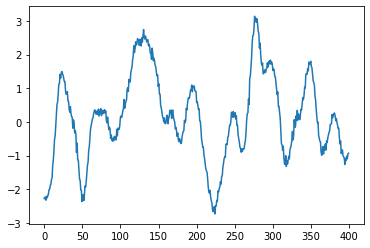

In [38]:
plt.plot(xd, yd)

In [39]:
OI = OptimalInterpJax(xd[:,None], xd[:,None], noise, covfunc, covparams)
lml_j = OI.log_marg_likelihood(yds[:,None])
lml_j, lml_s, lml_j - lml_s

(DeviceArray(288.09335475, dtype=float64),
 288.09335475019634,
 DeviceArray(0., dtype=float64))

# Try optimisation

See e.g. https://tinygp.readthedocs.io/en/latest/tutorials/kernels.html

In [40]:
import optax
from time import time

In [47]:
%%time
# This is hard-wired to the case above
def build_gp(theta):
    params = (theta['eta'], theta['l'])
    #return OptimalInterpJax(xd[:,None], xd[:,None], jnp.exp(theta['log_noise']), covfunc, params)
    return OptimalInterpJax(xd[:,None], xd[:,None], theta['noise'], covfunc, params)

@jax.jit
@jax.value_and_grad
def loss(theta):
    return -build_gp(theta).log_marg_likelihood(yds[:,None])

# params = {'log_noise':np.log(0.01), 'eta':0.6, 'l':1.}
params = {'noise':0.01, 'eta':0.6, 'l':1.}


opt = optax.sgd(learning_rate=3e-4)
# opt = optax.adam(learning_rate=5e-2)

opt_state = opt.init(params)
for i in range(1000):
    tic=time()
    loss_val, grads = loss(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 25 == 0:
        print(f'step {i}, time/step: {time()-tic} [s], loss: {loss_val}')
    #     if loss_val < -5000:
    #         print(f'step {i}, loss: {loss_val}')
    #         break

print(params['noise'], noise)
print(params['eta'], covparams[0])
print(params['l'], covparams[1])

step 0, time/step: 0.4829273223876953 [s], loss: 484.95774505278195
step 25, time/step: 0.014216899871826172 [s], loss: 1748.846102096522
step 50, time/step: 0.01871943473815918 [s], loss: 1737.9155045496632
step 75, time/step: 0.016641616821289062 [s], loss: 1726.4899778313097
step 100, time/step: 0.017374753952026367 [s], loss: 1714.5228283901454
step 125, time/step: 0.01737833023071289 [s], loss: 1701.9604555240371
step 150, time/step: 0.017574548721313477 [s], loss: 1688.7409232950217
step 175, time/step: 0.018138408660888672 [s], loss: 1674.7921444671001
step 200, time/step: 0.017889976501464844 [s], loss: 1660.0295431187042
step 225, time/step: 0.017128705978393555 [s], loss: 1644.353006035257
step 250, time/step: 0.01726078987121582 [s], loss: 1627.6428473620056
step 275, time/step: 0.017585277557373047 [s], loss: 1609.7543783769727
step 300, time/step: 0.017442941665649414 [s], loss: 1590.510463595707
step 325, time/step: 0.016878366470336914 [s], loss: 1569.6911002471534
step 

In [48]:
noise,covparams

(0.1, (1.35, 10.1))

In [49]:
%%time
# This is hard-wired to the case above
def build_gp(theta):
    params = (jnp.exp(theta['log_eta']), jnp.exp(theta['log_l']))
    return OptimalInterpJax(xd[:,None], xd[:,None], jnp.exp(theta['log_noise']), covfunc, params)

@jax.jit
@jax.value_and_grad
def loss(theta):
    return -build_gp(theta).log_marg_likelihood(yds[:,None])

params = {'log_noise':np.log(0.1), 'log_eta':np.log(0.3), 'log_l':np.log(1.1)}

opt = optax.sgd(learning_rate=5e-5)
# opt = optax.adam(learning_rate=1e-3)

opt_state = opt.init(params)
for i in range(1000):
    loss_val, grads = loss(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 25 == 0:
        print(f'step {i}, loss: {loss_val}')
    if loss_val < -5000:
        print(f'step {i}, loss: {loss_val}')
        break

print(jnp.exp(params['log_noise']), noise)
print(jnp.exp(params['log_eta']), covparams[0])
print(jnp.exp(params['log_l']), covparams[1])

step 0, loss: 953.387045425907
step 25, loss: -2.1962216356685644
step 50, loss: -122.62652139438683
step 75, loss: -185.97072723006158
step 100, loss: -227.59672748444655
step 125, loss: -254.18174791678814
step 150, loss: -268.87741470822243
step 175, loss: -275.86128749227237
step 200, loss: -279.578746777835
step 225, loss: -281.84368545312896
step 250, loss: -283.3257566935024
step 275, loss: -284.364393379181
step 300, loss: -285.13697780387974
step 325, loss: -285.733579018661
step 350, loss: -286.2041731249989
step 375, loss: -286.5803504660022
step 400, loss: -286.88399398705246
step 425, loss: -287.13102654073145
step 450, loss: -287.33335149493894
step 475, loss: -287.50002561910355
step 500, loss: -287.63803343160623
step 525, loss: -287.75282246304084
step 550, loss: -287.84868337587375
step 575, loss: -287.92902511522516
step 600, loss: -287.996577176217
step 625, loss: -288.0535402897058
step 650, loss: -288.10170002062625
step 675, loss: -288.14251332930826
step 700, lo

In [53]:
%%time

# Try putting all the input parameters into one vector

# This is hard-wired to the case above
def build_gp(theta):
    params = (jnp.exp(theta[1]), jnp.exp(theta[2]))
    return OptimalInterpJax(xd[:,None], xd[:,None], jnp.exp(theta[0]), covfunc, params)

@jax.jit
@jax.value_and_grad
def loss(theta):
    return -build_gp(theta).log_marg_likelihood(yds[:,None])

params = np.array([np.log(0.1), np.log(0.3), np.log(1.1)])

opt = optax.sgd(learning_rate=3e-4)
# opt = optax.adam(learning_rate=1e-3)

opt_state = opt.init(params)
for i in range(1000):
    loss_val, grads = loss(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 25 == 0:
        print(f'step {i}, loss: {loss_val}')
    if loss_val < -5000:
        print(f'step {i}, loss: {loss_val}')
        break

print(jnp.exp(params[0]), noise)
print(jnp.exp(params[1]), covparams[0])
print(jnp.exp(params[2]), covparams[1])

step 0, loss: 953.387045425907
step 25, loss: -271.82251379886463
step 50, loss: -285.475261157432
step 75, loss: -287.4371698075048
step 100, loss: -288.0349320723427
step 125, loss: -288.2472678249005
step 150, loss: -288.32887095319336
step 175, loss: -288.361674602235
step 200, loss: -288.37522410767644
step 225, loss: -288.38091615620704
step 250, loss: -288.38333317840977
step 275, loss: -288.38436664240874
step 300, loss: -288.38481051397764
step 325, loss: -288.3850017142918
step 350, loss: -288.38508423253813
step 375, loss: -288.385119890414
step 400, loss: -288.3851353116154
step 425, loss: -288.3851419845254
step 450, loss: -288.3851448729878
step 475, loss: -288.38514612359063
step 500, loss: -288.3851466651414
step 525, loss: -288.3851468996728
step 550, loss: -288.3851470012502
step 575, loss: -288.3851470452455
step 600, loss: -288.3851470643016
step 625, loss: -288.38514707255456
step 650, loss: -288.38514707613183
step 675, loss: -288.38514707767786
step 700, loss: -2